### Spis Treści
1. [Biblioteki](#Biblioteki)
2. [Ścieżki do obrazów](#Ścieżki-do-obrazów)
3. [Przygotowanie zdjęć do klasyfikacji](#Przygotowanie-zdjęć-do-klasyfikacji)
4. [Implementacja własnego modelu klasyfikacyjnego](#Implementacja-własnego-modelu-klasyfikacyjnego)
5. [Wykorzystanie sieci DenseNet121 (Model Fine-Tuning)](#Wykorzystanie-sieci-DenseNet121-(Model-Fine-Tuning))
6. [Ocena jakości modelu](#Ocena-jakości-modelu)

---

## Fragment kodu do pracy w Google Colab

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Rozpakowanie danych do folderu na dysku Google (należy utworzyć folder "Projekt DL" i tam umieścić zip)
#!unzip '/content/drive/My Drive/Projekt DL/Train_Test_Split.zip' -d '/content/drive/My Drive/Projekt DL'

In [2]:
train_path = '/content/drive/My Drive/Projekt DL/Cat Breeds Split/train'
test_path = '/content/drive/My Drive/Projekt DL/Cat Breeds Split/test'
val_path = '/content/drive/My Drive/Projekt DL/Cat Breeds Split/val'

---

## Biblioteki

In [12]:
# Podstawowe
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Do obróbki danych
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.preprocessing.image import ImageDataGenerator

# Do DL
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

from keras.applications import DenseNet121
from keras.applications import VGG16
from keras.applications import InceptionV3

#Zmienienie formatu zapisu danych numerycznych na dwie cyfry po przecinku.
pd.options.display.float_format = '{:.2f}'.format

## Ścieżki do obrazów
W tym miejscu należy zmienić ścieżki według tego gdzie znajdują się foldery z obrazami, które utworzyliśmy za pomocą tego skryptu: [skrypt.ipynb](https://github.com/infoshareacademy/jdszr13-python_dynamites/blob/szymoncyranowicz/projekt_dl/skrypt.ipynb). Jeżeli robicie w Google Colab to nie uruchamiajcie tej komórki.

In [4]:
train_path = 'Cat_Breeds_Split5\Train'
test_path = 'Cat_Breeds_Split5\Test'
val_path = 'Cat_Breeds_Split5\Val'

## Przygotowanie zdjęć do klasyfikacji

In [ ]:
#Usunięcie problematycznych zdjęć https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/discussion/438473
#os.remove(os.path.join(train_path, 'cat', '666.jpg'))
#os.remove(os.path.join(val_path, 'dog', '11702.jpg'))

In [5]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    shear_range=0.1,
    zoom_range=0.1, # Randomly zoom image
    horizontal_flip=True, # randomly flip images
    vertical_flip=True,  # randomly flip images
    fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train = train_gen.flow_from_directory(
    train_path,
    batch_size=20,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224))

test = test_gen.flow_from_directory(
    test_path,
    batch_size=20,
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224))

val = test_gen.flow_from_directory(
    val_path,
    batch_size=20,
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224))

print('\n',train.class_indices)

Found 1500 images belonging to 5 classes.
Found 190 images belonging to 5 classes.
Found 185 images belonging to 5 classes.

 {'Bengal': 0, 'Birman': 1, 'British Shorthair': 2, 'Maine Coon': 3, 'Tuxedo': 4}


## Podgląd zdjęć po obróbce

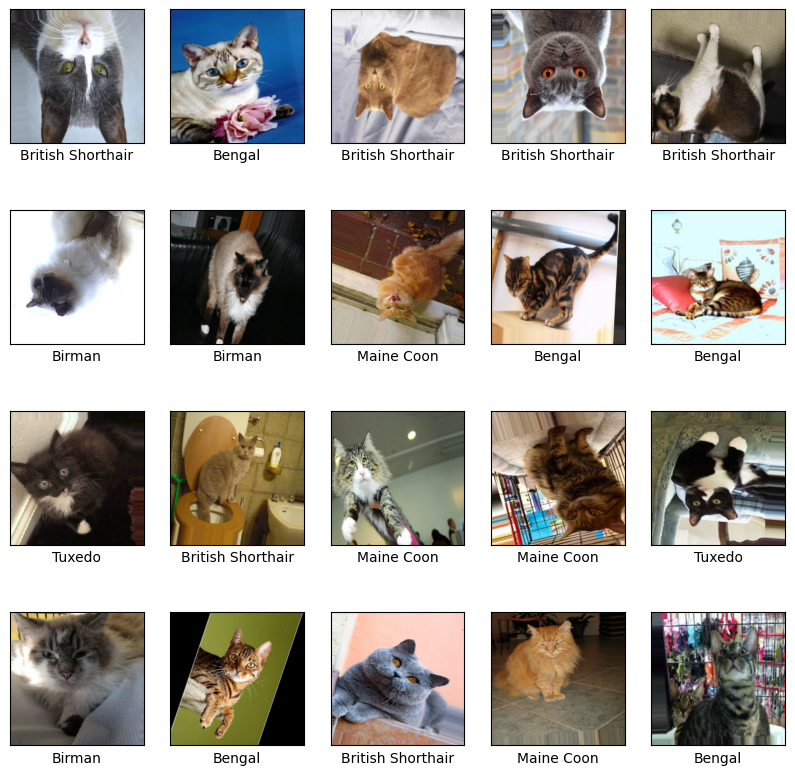

In [7]:
img, label = train.__getitem__(0)

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i])
    index = [i for i, e in enumerate(label[i]) if e != 0][0]
    cat_breed = list(filter(lambda x: train.class_indices[x] == index, train.class_indices))[0]
    plt.xlabel(cat_breed)
plt.show()

## Implementacja własnego modelu klasyfikacyjnego

In [9]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='AUC')]

adam_001 = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Wykorzystanie sieci InceptionV3 (Model Fine-Tuning)

In [15]:
inc_base_model = InceptionV3(input_shape=(244, 244, 3),
                               pooling = 'avg',
                               include_top = False,
                               weights='imagenet')

inc_model = tf.keras.Sequential([
        inc_base_model,
        Flatten(),
        Dropout(0.25),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(5, activation="softmax")])

inc_model.compile(loss='categorical_crossentropy',
                  optimizer = adam_001,
                  metrics = METRICS)

In [16]:
inc_history = inc_model.fit(
    train,
    epochs = 10,
    validation_data = val,
    steps_per_epoch = 50,
    validation_steps = 10,
    callbacks = callbacks,
    )

Epoch 1/10
50/50 [==============================] - 139s 3s/step - loss: 1.4135 - accuracy: 0.4680 - precision: 0.6520 - recall: 0.2643 - AUC: 0.7756 - val_loss: 5855.9360 - val_accuracy: 0.2000 - val_precision: 0.2000 - val_recall: 0.2000 - val_AUC: 0.5000 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 120s 2s/step - loss: 1.0283 - accuracy: 0.6490 - precision: 0.7577 - recall: 0.4940 - AUC: 0.8772 - val_loss: 1181.7449 - val_accuracy: 0.2000 - val_precision: 0.2000 - val_recall: 0.2000 - val_AUC: 0.5000 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 116s 2s/step - loss: 0.9955 - accuracy: 0.6340 - precision: 0.7671 - recall: 0.4940 - AUC: 0.8805 - val_loss: 2.3653 - val_accuracy: 0.2054 - val_precision: 0.2171 - val_recall: 0.1514 - val_AUC: 0.5131 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 117s 2s/step - loss: 0.8961 - accuracy: 0.6780 - precision: 0.7871 - recall: 0.5730 - AUC: 0.9010 - val_loss: 21.1471 - val_accuracy: 0.33

In [24]:
inc_history = inc_model.fit(
    train,
    epochs = 5,
    validation_data = val,
    steps_per_epoch = 50,
    validation_steps = 10,
    callbacks = callbacks,
    )

Epoch 1/5
50/50 [==============================] - 114s 2s/step - loss: 0.1668 - accuracy: 0.9400 - precision: 0.9464 - recall: 0.9360 - AUC: 0.9955 - val_loss: 0.2502 - val_accuracy: 0.9027 - val_precision: 0.9218 - val_recall: 0.8919 - val_AUC: 0.9903 - lr: 1.2500e-04
Epoch 2/5
50/50 [==============================] - 115s 2s/step - loss: 0.1772 - accuracy: 0.9370 - precision: 0.9442 - recall: 0.9300 - AUC: 0.9939 - val_loss: 0.1938 - val_accuracy: 0.9189 - val_precision: 0.9438 - val_recall: 0.9081 - val_AUC: 0.9931 - lr: 1.2500e-04
Epoch 3/5
50/50 [==============================] - 116s 2s/step - loss: 0.1517 - accuracy: 0.9460 - precision: 0.9524 - recall: 0.9400 - AUC: 0.9958 - val_loss: 0.2038 - val_accuracy: 0.9189 - val_precision: 0.9341 - val_recall: 0.9189 - val_AUC: 0.9929 - lr: 1.2500e-04
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9500 - precision: 0.9554 - recall: 0.9430 - AUC: 0.9965
Epoch 4: ReduceLROnPlateau reducing learnin

In [25]:
inc_model.save('breeds5_inc_model_30ep.keras')
inc_model.save('breeds5_inc_model_30ep.h5')

## Ocena jakości modelu

In [14]:
# Ścieżka do zapisanego modelu
model_path = 'breeds5_inc_model_30ep.h5'

# Wczytanie modelu
inc_model_saved = load_model(model_path)

test_inc_evaluation = inc_model_saved.evaluate(test)

print(f"Test Accuracy: {test_inc_evaluation[1]:.4f}")
print(f"Test Precision: {test_inc_evaluation[2]:.4f}")
print(f"Test Recall: {test_inc_evaluation[3]:.4f}")
print(f"Test AUC: {test_inc_evaluation[4]:.4f}")

train_inc_evaluation = inc_model_saved.evaluate(train)

print(f"Train Accuracy: {train_inc_evaluation[1]:.4f}")
print(f"Train Precision: {train_inc_evaluation[2]:.4f}")
print(f"Train Recall: {train_inc_evaluation[3]:.4f}")
print(f"Train AUC: {train_inc_evaluation[4]:.4f}")

val_inc_evaluation = inc_model_saved.evaluate(val)

print(f"Val Accuracy: {val_inc_evaluation[1]:.4f}")
print(f"Val Precision: {val_inc_evaluation[2]:.4f}")
print(f"Val Recall: {val_inc_evaluation[3]:.4f}")
print(f"Val AUC: {val_inc_evaluation[4]:.4f}")

10/10 [==============================] - 5s 349ms/step - loss: 0.1127 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - AUC: 0.9983
Test Accuracy: 0.9684
Test Precision: 0.9684
Test Recall: 0.9684
Test AUC: 0.9983
75/75 [==============================] - 35s 463ms/step - loss: 0.0653 - accuracy: 0.9827 - precision: 0.9846 - recall: 0.9820 - AUC: 0.9994
Train Accuracy: 0.9827
Train Precision: 0.9846
Train Recall: 0.9820
Train AUC: 0.9994
10/10 [==============================] - 4s 368ms/step - loss: 0.1947 - accuracy: 0.9189 - precision: 0.9489 - recall: 0.9027 - AUC: 0.9929
Val Accuracy: 0.9189
Val Precision: 0.9489
Val Recall: 0.9027
Val AUC: 0.9929
